# Installation data preparation
This notebook aims to provide installation data using the best data available to us. We have access to several information:
- actuals data (effective hydro, solar and wind production, also load and total generation)
- GSE data for installations

Our objective is to produce a dataframe that contains the following informations per each zone:
- installation for each source (fitted with GSE data, normalized over max)
- detrended generation for each source (using the fitted installation, normalized with StandardScaler)
- ratio ((hydro + solar + wind) / load). This is used as label for classification, and it is computed on the measured productions and load (non detrended)

# 0: Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import pyarrow # needed for importing dataframes
import warnings
import os

from time import time

# decomposition libs
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

warnings.filterwarnings('ignore') # silence warnings

sel_zone = 'IT_SUD' # select the zone to produce the input for

register_matplotlib_converters()
sns.set_style("darkgrid")

# setup font sizes for images
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

# 1: Zone characterisctics 
### NOTE: 
This code runs automatically for all ITALY ZONES

In [2]:
italy_zones = ['IT_CALA','IT_CNOR','IT_CSUD','IT_SARD','IT_SICI','IT_SUD','IT_NORD']

regions = {
    'IT_NORD':["Valle D'Aosta","Liguria","Piemonte","Lombardia","Veneto","Provincia Autonoma di Trento","Provincia Autonoma di Bolzano","Trentino Alto Adige","Friuli Venezia Giulia","Emilia Romagna"],
    'IT_CNOR':["Toscana","Marche","Umbria"],
    'IT_CSUD':["Lazio","Abruzzo","Campania"],
    'IT_SUD':["Molise","Puglia","Basilicata"],
    'IT_CALA':["Calabria"],
    'IT_SARD':["Sardegna"],
    'IT_SICI':["Sicilia"]
}


# 2: Installation fitting
In this section all kinds of installations are analyzed singularly. Since the installations change zone by zone and cannot be predicted easily, they have to be fitted one by one "by hand".

## 2.0: fitting functions
These functions are going to be used to fit based on values of installation

In [3]:
def lin_fit(xp, yp, xv):
    # Perform linear fit (degree 1 polynomial: y = a*x + b)
    a, b = np.polyfit(xp, yp, 1)
    # Compute fitted y values for xv
    yv = a * xv + b
    return xv, yv, a, b

def parab_fit(xp, yp, xv):
    a, b, c = np.polyfit(xp, yp, 2)
    # Compute fitted y values for xv
    yv = a * xv**2 + b * xv + c
    return xv, yv, a, b, c


## 2.1: IT_NORD
### 2.1.1: IT_NORD_SOLAR

In [4]:
# Selected zone
sel_zone = 'IT_NORD'
# for saving installation data
df_installed_nord = pd.DataFrame()

# making directory for saving plots
directory_name = f'2_plots/{sel_zone}'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

# directory for saving actuals
directory_name = f'2_outputs'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory '2_plots/IT_NORD' already exists.
Directory '2_outputs' already exists.


### getting a valid time parameter (from actuals files)

In [5]:
years = [2022,2023,2024] # selection of years
df_actuals = pd.DataFrame()

# extract actuals files
for year in years:
    filename = f"2_gse_data/{year}_actuals.zst"
    df = pd.read_parquet(filename)  # this reads .zst files efficiently
    df = df[df['zone'] == sel_zone]
    df_actuals = pd.concat([df_actuals, df])

# check for duplicates date time information
df_actuals['datetime'] = df_actuals.index.tz_localize(None)
num_duplicates = df_actuals.duplicated(subset='datetime').sum()
print(f"Number of duplicate datetime entries in {sel_zone} actuals: {num_duplicates}")

# remove last day of 2024 (problem in acquisition of data
df_actuals = df_actuals[:(np.shape(df_actuals)[0]-96)]

# grouping by hours (2024 changes timeframe acquisition)
df_actuals = df_actuals.resample('1h').agg({'solar': 'sum',
                                        'wind': 'sum',
                                        'hydro': 'sum',
                                        'generation':'sum',
                                        'load':'sum'}) 

# then making a growing time param
df_actuals['time'] = np.linspace(0, 1, len(df_actuals))


Number of duplicate datetime entries in IT_NORD actuals: 0


In [6]:
# data from 2022 and 2023
solar2223 = pd.read_excel('2_gse_data/solare_GSE_2021_2023.xlsx') 
solar2223 = solar2223[solar2223['Regione'].isin(regions[sel_zone])]  # select regions
solar2223 = solar2223.groupby(['Anno'], as_index = False)['Potenza installata (MW)'].agg(Solar_installed = 'sum') # sum over regions
solar2223

,Anno,Solar_installed
0,2021,10196.34
1,2022,11523.09
2,2023,14598.10


In [7]:
# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
solar24 = installation24[installation24['Fonte']=='Solare']  # select source

# select regions and order by month
solar24 = solar24[solar24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
solar24 = solar24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
solar24 = solar24.groupby(['Anno','Mese'], as_index = False).sum()
# compute installed power as cumsum
solar24['Solar_installed'] = solar24['Potenza attiva nominale (MW)'].cumsum()
solar24 = solar24[['Anno','Mese','Solar_installed']]
solar24

,Anno,Mese,Solar_installed
0,2024,1.0,306.99382
1,2024,2.0,577.16171
2,2024,3.0,797.25466
3,2024,4.0,983.36917
4,2024,5.0,1209.90862
5,2024,6.0,1410.48538
6,2024,7.0,1612.11453
7,2024,8.0,1759.58910
8,2024,9.0,1968.63639
9,2024,10.0,2188.44418


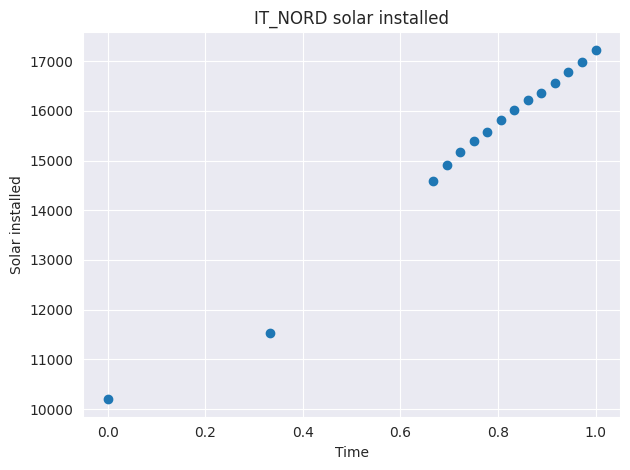

In [8]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
solar2223['time'] = (solar2223['Anno'] - min(solar2223['Anno']))*1.0/3 
solar24['time'] = solar24['Mese']/12.0 / 3 + max(solar2223['time'])

# adding to solar24 the latest installation of 2023
solar24['Solar_installed'] = solar24['Solar_installed'] + solar2223['Solar_installed'].iloc[-1]

# removing extra features
solar2223 = solar2223[['Anno','time','Solar_installed']]
solar24 = solar24[['Anno','time','Solar_installed']]

# concatenate
solar = pd.concat([solar2223,solar24], ignore_index = True)
solar
plt.scatter(solar['time'],solar['Solar_installed'])
plt.xlabel('Time')
plt.ylabel('Solar installed')
plt.title(f'{sel_zone} solar installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/solar_installed.png')
plt.show()

On the assumption that in the first period the trend was parabolic, we fit with a second degree polinomia for time < 0.68, and from there with a straight line

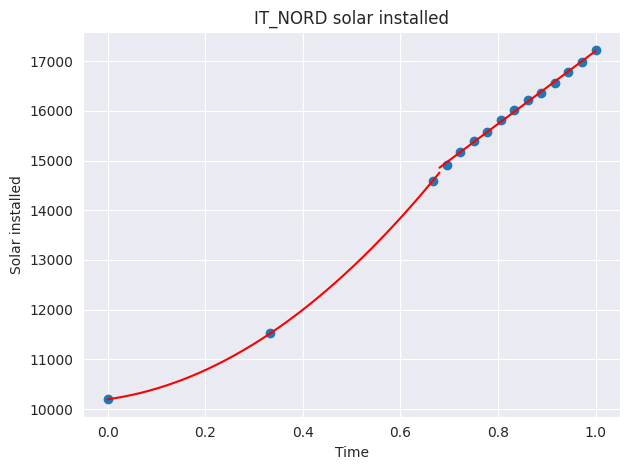

In [9]:
# set threshold that delines where to stop fitting
threshold = 0.68

# FIT 1     FIT 1    FIT 1    FIT 1     FIT 1    FIT 1    FIT 1    FIT 1    FIT 1
# get the points to fit at left (parabolic)
x_to_fit1 = solar[solar['time'] < threshold]['time']
y_to_fit1 = solar[solar['time'] < threshold]['Solar_installed']
# get the points for plotting line
x_fitted1 = df_actuals[df_actuals['time'] < threshold]['time']
# fitting
xv1, yv1, a1, b1, c1 = parab_fit(x_to_fit1, y_to_fit1, x_fitted1)


# FIT 2     FIT 2    FIT 2    FIT 2     FIT 2    FIT 2    FIT 2    FIT 2    FIT 2
# get the points to fit at right (linear)
x_to_fit2 = solar[solar['time'] >= threshold]['time']
y_to_fit2 = solar[solar['time'] >= threshold]['Solar_installed']
# get the points for plotting line
x_fitted2 = df_actuals[df_actuals['time'] >= threshold]['time']
# fitting
xv2, yv2, a2, b2 = lin_fit(x_to_fit2, y_to_fit2, x_fitted2)

# plotting results
plt.scatter(solar['time'],solar['Solar_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.plot(xv2, yv2, color = 'red')
plt.xlabel('Time')
plt.ylabel('Solar installed')
plt.title(f'{sel_zone} solar installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/solar_installed_fitted.png')
plt.show()

In [10]:
# saving the fit results into actuals
df_actuals['solar_installed']=0.
df_actuals.loc[df_actuals['time']< threshold,'solar_installed']=yv1
df_actuals.loc[df_actuals['time']>= threshold,'solar_installed']=yv2
df_actuals


,solar,wind,hydro,generation,load,time,solar_installed
date_time,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.000000,10196.340000
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.000038,10196.391682
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.000076,10196.443387
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.000114,10196.495115
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.000152,10196.546866
...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,14.0,2271.0,15045.0,16115.0,0.999848,17204.457726
2024-12-30 20:00:00+00:00,0.0,8.0,1609.0,13161.0,14848.0,0.999886,17204.737136
2024-12-30 21:00:00+00:00,0.0,8.0,1313.0,11398.0,13473.0,0.999924,17205.016547


### 2.1.2 IT_NORD HYDRO

In [11]:
# data from 2022 and 2023
hydro2223 = pd.read_excel('2_gse_data/idrico_GSE_2021_2023.xlsx') 
hydro2223 = hydro2223[hydro2223['Regione'].isin(regions[sel_zone])]  # select regions
hydro2223 = hydro2223.groupby(['Anno'], as_index = False)['Idrico'].agg(Hydro_installed = 'sum') # sum over regions
hydro2223

,Anno,Hydro_installed
0,2021,10149
1,2022,10187
2,2023,10221


In [12]:
# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
hydro24 = installation24[installation24['Fonte'] == 'Idroelettrico']  # select source

# select regions and order by month
hydro24 = hydro24[hydro24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
hydro24 = hydro24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
hydro24 = hydro24.groupby(['Anno','Mese'], as_index = False).sum()
# compute installed power as cumsum
hydro24['Hydro_installed'] = hydro24['Potenza attiva nominale (MW)'].cumsum()
hydro24 = hydro24[['Anno','Mese','Hydro_installed']]
hydro24

,Anno,Mese,Hydro_installed
0,2024,1.0,1.6740
1,2024,2.0,1.9090
2,2024,3.0,2.7680
3,2024,4.0,3.2680
4,2024,5.0,5.9180
5,2024,6.0,10.3270
6,2024,7.0,11.5970
7,2024,8.0,12.0677
8,2024,9.0,14.8677
9,2024,10.0,19.4617


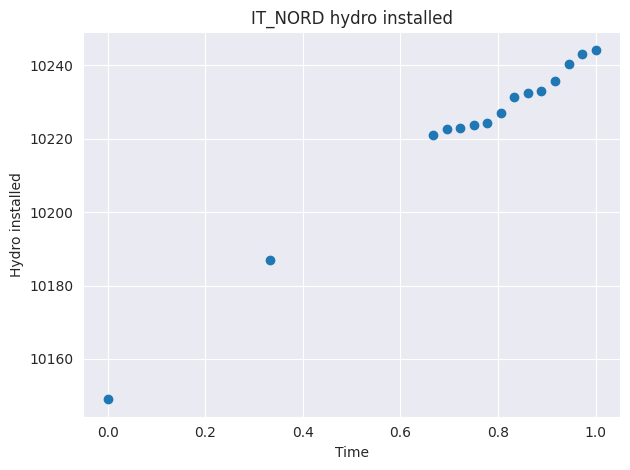

In [13]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
hydro2223['time'] = (hydro2223['Anno'] - min(hydro2223['Anno']))*1.0/3 
hydro24['time'] = hydro24['Mese']/12.0 / 3 + max(hydro2223['time'])

# adding to solar24 the latest installation of 2023
hydro24['Hydro_installed'] = hydro24['Hydro_installed'] + hydro2223['Hydro_installed'].iloc[-1]

# removing extra features
hydro2223 = hydro2223[['Anno','time','Hydro_installed']]
hydro24 = hydro24[['Anno','time','Hydro_installed']]

# concatenate
hydro = pd.concat([hydro2223,hydro24], ignore_index = True)
hydro
plt.scatter(hydro['time'],hydro['Hydro_installed'])
plt.xlabel('Time')
plt.ylabel('Hydro installed')
plt.title(f'{sel_zone} hydro installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/hydro_installed.png')
plt.show()

two trends can be seen here: one going from 0 to about 0.7 and one from 0.7 to 1. Both of these are linear, so we perform 2 linear fits

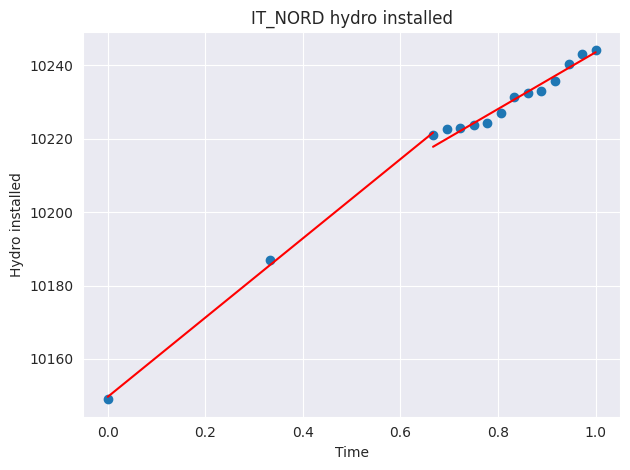

In [14]:
# set threshold that delines where to stop fitting
threshold = 0.6667

# FIT 1     FIT 1    FIT 1    FIT 1     FIT 1    FIT 1    FIT 1    FIT 1    FIT 1
# get the points to fit at left (linear)
x_to_fit1 = hydro[hydro['time'] < threshold]['time']
y_to_fit1 = hydro[hydro['time'] < threshold]['Hydro_installed']
# get the points for plotting line
x_fitted1 = df_actuals[df_actuals['time'] < threshold]['time']
# fitting
xv1, yv1, a1, b1 = lin_fit(x_to_fit1, y_to_fit1, x_fitted1)


# FIT 2     FIT 2    FIT 2    FIT 2     FIT 2    FIT 2    FIT 2    FIT 2    FIT 2
# get the points to fit at right (linear)
x_to_fit2 = hydro[hydro['time'] >= threshold]['time']
y_to_fit2 = hydro[hydro['time'] >= threshold]['Hydro_installed']
# get the points for plotting line
x_fitted2 = df_actuals[df_actuals['time'] >= threshold]['time']
# fitting
xv2, yv2, a2, b2 = lin_fit(x_to_fit2, y_to_fit2, x_fitted2)

# plotting results
plt.scatter(hydro['time'],hydro['Hydro_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.plot(xv2, yv2, color = 'red')
plt.xlabel('Time')
plt.ylabel('Hydro installed')
plt.title(f'{sel_zone} hydro installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/hydro_installed_fitted.png')
plt.show()

In [15]:
# saving the fit results into actuals
df_actuals['hydro_installed']=0.
df_actuals.loc[df_actuals['time']< threshold,'hydro_installed']=yv1
df_actuals.loc[df_actuals['time']>= threshold,'hydro_installed']=yv2
df_actuals


,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed
date_time,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.000000,10196.340000,10149.666667
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.000038,10196.391682,10149.670776
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.000076,10196.443387,10149.674886
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.000114,10196.495115,10149.678996
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.000152,10196.546866,10149.683106
...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,14.0,2271.0,15045.0,16115.0,0.999848,17204.457726,10243.570173
2024-12-30 20:00:00+00:00,0.0,8.0,1609.0,13161.0,14848.0,0.999886,17204.737136,10243.573115
2024-12-30 21:00:00+00:00,0.0,8.0,1313.0,11398.0,13473.0,0.999924,17205.016547,10243.576057


### 2.1.3 IT_NORD WIND INSTALLED

In [16]:
# data from 2022 and 2023
wind2223 = pd.read_csv('2_gse_data/eolico_GSE_2021_2023.csv', sep =';') 
print(wind2223.columns)
wind2223 = wind2223[wind2223['Regione'].isin(regions[sel_zone])]  # select regions
wind2223 = wind2223.groupby(['Anno'], as_index = False)['Valore'].agg(Wind_installed = 'sum') # sum over regions
wind2223


Index(['Regione', 'Valore', 'Anno'], dtype='object')


,Anno,Wind_installed
0,2021,164
1,2022,196
2,2023,198


In [17]:
# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
wind24 = installation24[installation24['Fonte'] == 'Eolico']  # select source

# select regions and order by month
wind24 = wind24[wind24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
wind24 = wind24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
wind24 = wind24.groupby(['Anno','Mese'], as_index = False).sum()

# compute installed power as cumsum
wind24['Wind_installed'] = wind24['Potenza attiva nominale (MW)'].cumsum()
wind24 = wind24[['Anno','Mese','Wind_installed']]
wind24

,Anno,Mese,Wind_installed
0,2024,1.0,4.2600
1,2024,3.0,10.2600
2,2024,12.0,10.2708


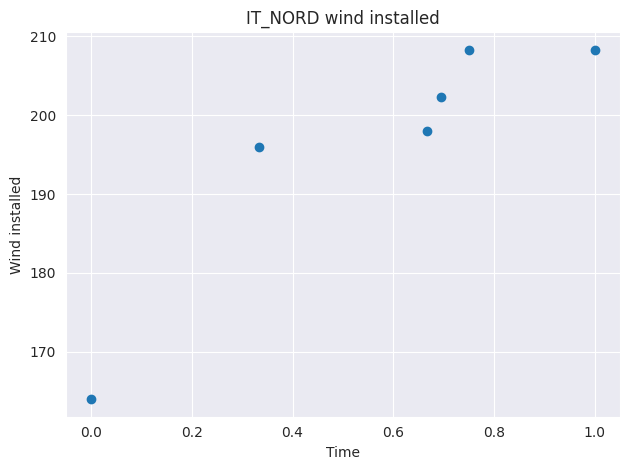

In [18]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
wind2223['time'] = (wind2223['Anno'] - min(wind2223['Anno']))*1.0/3 
wind24['time'] = wind24['Mese']/12.0 / 3 + max(wind2223['time'])

# adding to solar24 the latest installation of 2023
wind24['Wind_installed'] = wind24['Wind_installed'] + wind2223['Wind_installed'].iloc[-1]

# removing extra features
wind2223 = wind2223[['Anno','time','Wind_installed']]
wind24 = wind24[['Anno','time','Wind_installed']]

# concatenate
wind = pd.concat([wind2223,wind24], ignore_index = True)
wind
plt.scatter(wind['time'],wind['Wind_installed'])
plt.xlabel('Time')
plt.ylabel('Wind installed')
plt.title(f'{sel_zone} wind installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/wind_installed.png')
plt.show()

The data is sparse and not so informative. We fit segments point by point basically

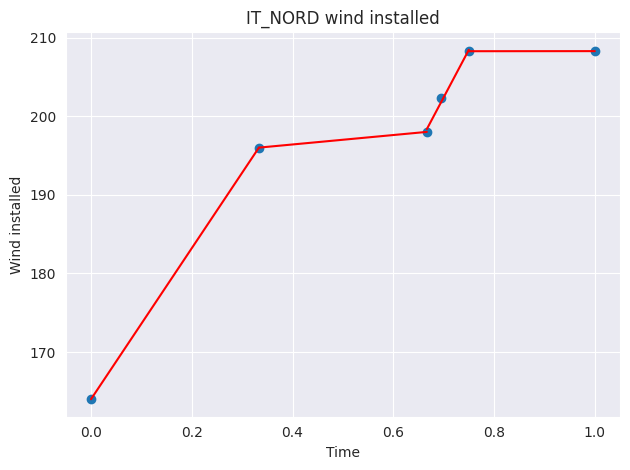

In [19]:
# FIT 1     FIT 1    FIT 1    FIT 1     FIT 1    FIT 1    FIT 1    FIT 1    FIT 1
# get the points to fit first 2 points (linear)
x_to_fit1 = wind['time'].iloc[:2]
y_to_fit1 = wind['Wind_installed'].iloc[:2]
# get the points for plotting line
x_fitted1 = df_actuals[df_actuals['time'] < wind['time'].iloc[1]]['time']
# fitting
xv1, yv1, a1, b1 = lin_fit(x_to_fit1, y_to_fit1, x_fitted1)


# FIT 2     FIT 2    FIT 2    FIT 2     FIT 2    FIT 2    FIT 2    FIT 2    FIT 2
# get the points to fit second and third point
x_to_fit2 = wind['time'].iloc[1:3]
y_to_fit2 = wind['Wind_installed'].iloc[1:3]
# get the points for plotting line
x_fitted2 = df_actuals[df_actuals['time'] >= wind['time'].iloc[1]]['time']
x_fitted2 = x_fitted2[x_fitted2 <= wind['time'].iloc[2]]
# fitting
xv2, yv2, a2, b2 = lin_fit(x_to_fit2, y_to_fit2, x_fitted2)


# FIT 3    FIT 3    FIT 3    FIT 3     FIT 3    FIT 3    FIT 3    FIT 3    FIT 3
# get the points to fit second and third point
x_to_fit3 = wind['time'].iloc[2:5]
y_to_fit3 = wind['Wind_installed'].iloc[2:5]
# get the points for plotting line
x_fitted3 = df_actuals[df_actuals['time'] >= wind['time'].iloc[2]]['time']
x_fitted3 = x_fitted3[x_fitted3 <= wind['time'].iloc[4]]
# fitting
xv3, yv3, a3, b3 = lin_fit(x_to_fit3, y_to_fit3, x_fitted3)


# FIT 4    FIT 4    FIT 4    FIT 4     FIT 4    FIT 4    FIT 4    FIT 4    FIT 4
# get the points to fit second and third point
x_to_fit4 = wind['time'].iloc[4:]
y_to_fit4 = wind['Wind_installed'].iloc[4:]
# get the points for plotting line
x_fitted4 = df_actuals[df_actuals['time'] >= wind['time'].iloc[4]]['time']
# fitting
xv4, yv4, a4, b4 = lin_fit(x_to_fit4, y_to_fit4, x_fitted4)

# plotting results
plt.scatter(wind['time'],wind['Wind_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.plot(xv2, yv2, color = 'red')
plt.plot(xv3, yv3, color = 'red')
plt.plot(xv4, yv4, color = 'red')
plt.xlabel('Time')
plt.ylabel('Wind installed')
plt.title(f'{sel_zone} wind installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/wind_installed_fitted.png')
plt.show()

In [20]:
# assign values to actuals df
df_actuals['wind_installed'] = 0.0
df_actuals.loc[df_actuals['time'] < wind['time'].iloc[1], 'wind_installed'] = yv1.values
mask2 = (df_actuals['time'] >= wind['time'].iloc[1]) & (df_actuals['time'] <= wind['time'].iloc[2])
df_actuals.loc[mask2, 'wind_installed'] = yv2.values
mask3 = (df_actuals['time'] > wind['time'].iloc[2]) & (df_actuals['time'] <= wind['time'].iloc[4])
df_actuals.loc[mask3, 'wind_installed'] = yv3.values
df_actuals.loc[df_actuals['time'] > wind['time'].iloc[4], 'wind_installed'] = yv4.values
df_actuals

,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed,wind_installed
date_time,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.000000,10196.340000,10149.666667,164.000000
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.000038,10196.391682,10149.670776,164.003653
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.000076,10196.443387,10149.674886,164.007306
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.000114,10196.495115,10149.678996,164.010959
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.000152,10196.546866,10149.683106,164.014612
...,...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,14.0,2271.0,15045.0,16115.0,0.999848,17204.457726,10243.570173,208.270793
2024-12-30 20:00:00+00:00,0.0,8.0,1609.0,13161.0,14848.0,0.999886,17204.737136,10243.573115,208.270795
2024-12-30 21:00:00+00:00,0.0,8.0,1313.0,11398.0,13473.0,0.999924,17205.016547,10243.576057,208.270797


### 2.1.4 IT_NORD REMOVING ACTUALS OUTLIERS
There are weird outliers in actuals dataset that really do not resemble any physical quantity. We'll just remove them

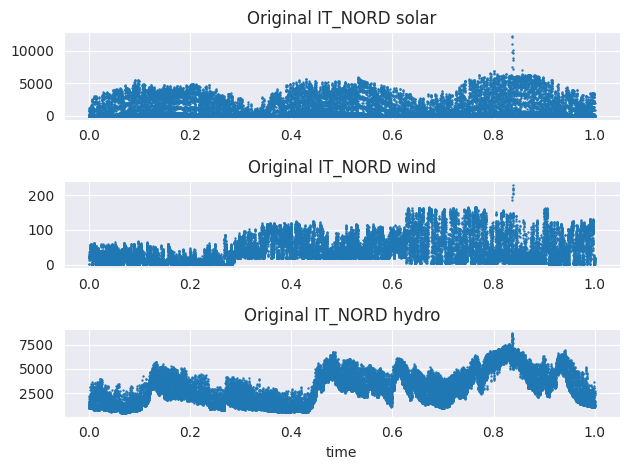

In [21]:
fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar'], s =0.5)
ax[1].scatter(df_actuals['time'],df_actuals['wind'], s =0.5)
ax[2].scatter(df_actuals['time'],df_actuals['hydro'], s =0.5)
ax[0].set_title(f'Original {sel_zone} solar')
ax[1].set_title(f'Original {sel_zone} wind')
ax[2].set_title(f'Original {sel_zone} hydro')
ax[2].set_xlabel('time')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/original_actuals_features.png')
plt.show()

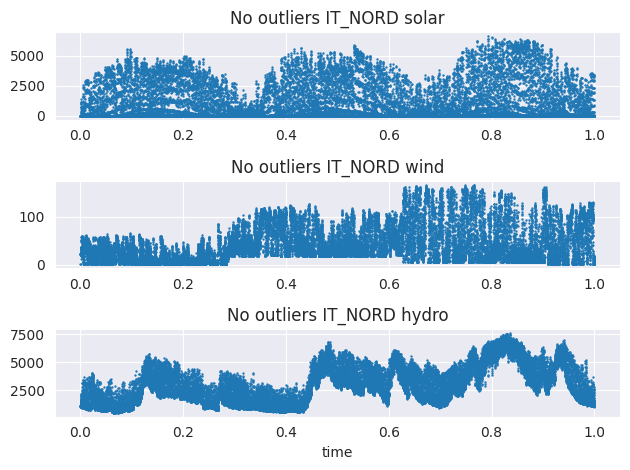

In [22]:
# removing outliers
df_actuals = df_actuals[df_actuals['solar']< 6700]
df_actuals = df_actuals[df_actuals['wind']< 180]
df_actuals = df_actuals[df_actuals['hydro']< 7600]

fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar'], s =0.5)
ax[1].scatter(df_actuals['time'],df_actuals['wind'], s =0.5)
ax[2].scatter(df_actuals['time'],df_actuals['hydro'], s =0.5)
ax[0].set_title(f'No outliers {sel_zone} solar')
ax[1].set_title(f'No outliers {sel_zone} wind')
ax[2].set_title(f'No outliers {sel_zone} hydro')
ax[2].set_xlabel('time')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/no_outliers_actuals_features.png')
plt.show()

### 2.1.5 Adjusting wind offset

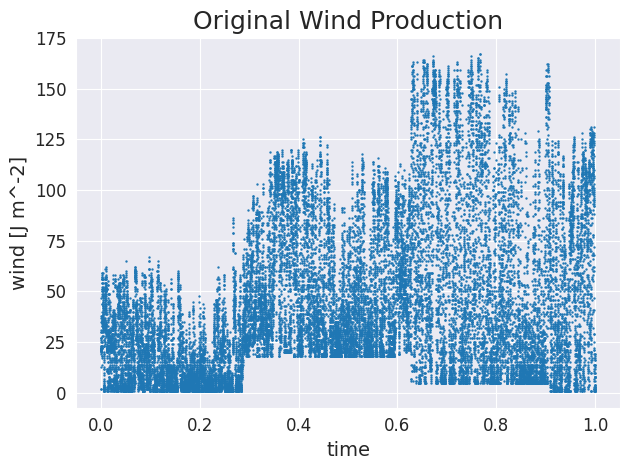

In [23]:
feature = 'wind'
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

plt.scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)
plt.title('Original Wind Production', fontsize = 18)
feature = feature + ' [J m^-2]'
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel(feature, fontsize = labelfontsize)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}_{feature}_plot_original.png')
plt.show()

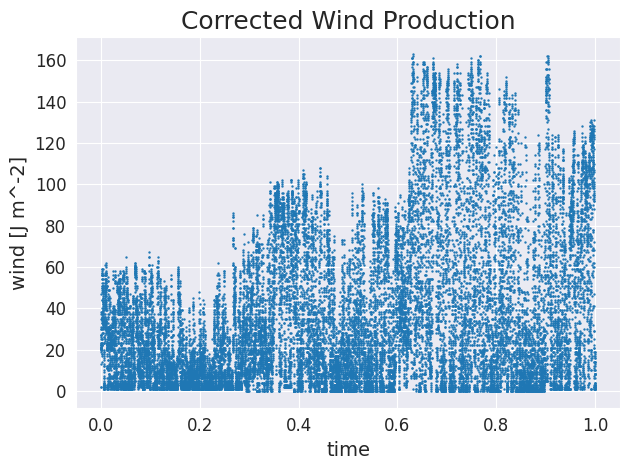

In [24]:
df_actuals[(df_actuals['time'] >= 0.32) & (df_actuals['time'] <= 0.6)].min()

df_actuals.loc[
    (df_actuals['time'] >= 0.29) & (df_actuals['time'] <= 0.62), 'wind'
] = df_actuals.loc[
    (df_actuals['time'] >= 0.29) & (df_actuals['time'] <= 0.62), 'wind'
] - 18.0
df_actuals[(df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896)].min()
df_actuals.loc[
    (df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896), 'wind'
] = df_actuals.loc[
    (df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896), 'wind'
] - 5.0

feature = 'wind'
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

plt.scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)
plt.title('Corrected Wind Production', fontsize = 18)
feature = feature + ' [J m^-2]'
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel(feature, fontsize = labelfontsize)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}_{feature}_plot_offsetted.png')
plt.show()


### 2.1.6 IT_NORD DETRENDED PRODUCTIONS
Finally we detrend the production via dividing over the estimate for each installation. This way the detrended features are not comparable with the load, but represent the true correlation between production and meteo forecast

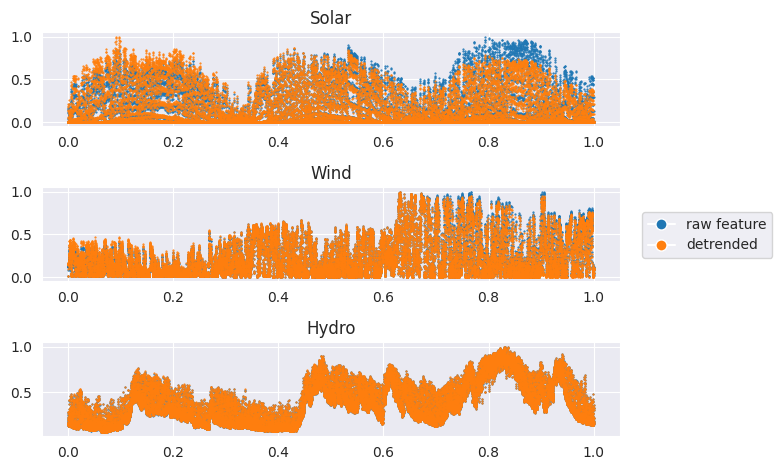

In [25]:
df_actuals['detrended_solar'] = df_actuals['solar'] / df_actuals['solar_installed']
df_actuals['detrended_wind'] = df_actuals['wind'] / df_actuals['wind_installed']
df_actuals['detrended_hydro'] = df_actuals['hydro'] / df_actuals['hydro_installed']

fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar']/max(df_actuals['solar']), s = 0.3, label = 'Original')
ax[0].scatter(df_actuals['time'],df_actuals['detrended_solar']/max(df_actuals['detrended_solar']), s = 0.3, label = 'Detrended')
ax[0].set_title('Solar')

ax[1].scatter(df_actuals['time'],df_actuals['wind']/max(df_actuals['wind']), s = 0.3, label = 'Original')
ax[1].scatter(df_actuals['time'],df_actuals['detrended_wind']/max(df_actuals['detrended_wind']), s = 0.3, label = 'Detrended')
ax[1].set_title('Wind')


ax[2].scatter(df_actuals['time'],df_actuals['hydro']/max(df_actuals['hydro']), s = 0.3, label = 'Original')
ax[2].scatter(df_actuals['time'],df_actuals['detrended_hydro']/max(df_actuals['detrended_hydro']), s = 0.3, label = 'Detrended')
ax[2].set_title('Hydro')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='raw feature',
           markerfacecolor='C0', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='detrended',
           markerfacecolor='C1', markersize=8), 
]
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

### 2.1.7 IT_NORD load computation
Easier said than done. Just the sum of the original renewable production over the effective load

In [26]:
df_actuals['ratio'] = (df_actuals['solar'] + df_actuals['wind'] + df_actuals['hydro']) / df_actuals['load']
df_actuals

,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed,wind_installed,detrended_solar,detrended_wind,detrended_hydro,ratio
date_time,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.000000,10196.340000,10149.666667,164.000000,0.0,0.012195,0.109363,0.105074
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.000038,10196.391682,10149.670776,164.003653,0.0,0.134143,0.104732,0.107917
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.000076,10196.443387,10149.674886,164.007306,0.0,0.134140,0.104141,0.112713
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.000114,10196.495115,10149.678996,164.010959,0.0,0.134137,0.107294,0.118166
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.000152,10196.546866,10149.683106,164.014612,0.0,0.134134,0.103747,0.110951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,14.0,2271.0,15045.0,16115.0,0.999848,17204.457726,10243.570173,208.270793,0.0,0.067220,0.221700,0.141793
2024-12-30 20:00:00+00:00,0.0,8.0,1609.0,13161.0,14848.0,0.999886,17204.737136,10243.573115,208.270795,0.0,0.038412,0.157074,0.108904
2024-12-30 21:00:00+00:00,0.0,8.0,1313.0,11398.0,13473.0,0.999924,17205.016547,10243.576057,208.270797,0.0,0.038412,0.128178,0.098048


In [27]:
# save the file 
df_actuals.to_csv(f'2_outputs/{sel_zone}_installation_detrended_actuals.csv')

## 2.2: IT_CNOR

In [28]:
# Selected zone
sel_zone = 'IT_CNOR'
# for saving installation data
df_installed_cnor = pd.DataFrame()

# making directory for saving plots
directory_name = f'2_plots/{sel_zone}'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

# directory for saving actuals
directory_name = f'2_outputs'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory '2_plots/IT_CNOR' already exists.
Directory '2_outputs' already exists.


### 2.2.1 IT_CNOR SOLAR
Getting a time parameter (actuals may be different depending on the zone, so we do it all back)

In [29]:
years = [2022,2023,2024] # selection of years
df_actuals = pd.DataFrame()

# extract actuals files
for year in years:
    filename = f"2_gse_data/{year}_actuals.zst"
    df = pd.read_parquet(filename)  # this reads .zst files efficiently
    df = df[df['zone'] == sel_zone]
    df_actuals = pd.concat([df_actuals, df])

# check for duplicates date time information
df_actuals['datetime'] = df_actuals.index.tz_localize(None)
num_duplicates = df_actuals.duplicated(subset='datetime').sum()
print(f"Number of duplicate datetime entries in {sel_zone} actuals: {num_duplicates}")

# remove last day of 2024 (problem in acquisition of data
df_actuals = df_actuals[:(np.shape(df_actuals)[0]-96)]

# grouping by hours (2024 changes timeframe acquisition)
df_actuals = df_actuals.resample('1h').agg({'solar': 'sum',
                                        'wind': 'sum',
                                        'hydro': 'sum',
                                        'generation':'sum',
                                        'load':'sum'}) 

# then making a growing time param
df_actuals['time'] = np.linspace(0, 1, len(df_actuals))

Number of duplicate datetime entries in IT_CNOR actuals: 0


In [30]:
# data from 2022 and 2023
solar2223 = pd.read_excel('2_gse_data/solare_GSE_2021_2023.xlsx') 
solar2223 = solar2223[solar2223['Regione'].isin(regions[sel_zone])]  # select regions
solar2223 = solar2223.groupby(['Anno'], as_index = False)['Potenza installata (MW)'].agg(Solar_installed = 'sum') # sum over regions
solar2223

,Anno,Solar_installed
0,2021,2571.17
1,2022,2801.22
2,2023,3217.30


In [31]:
# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
solar24 = installation24[installation24['Fonte']=='Solare']  # select source

# select regions and order by month
solar24 = solar24[solar24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
solar24 = solar24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
solar24 = solar24.groupby(['Anno','Mese'], as_index = False).sum()
# compute installed power as cumsum
solar24['Solar_installed'] = solar24['Potenza attiva nominale (MW)'].cumsum()
solar24 = solar24[['Anno','Mese','Solar_installed']]
solar24

,Anno,Mese,Solar_installed
0,2024,1.0,43.87151
1,2024,2.0,79.08476
2,2024,3.0,112.35232
3,2024,4.0,139.90308
4,2024,5.0,177.34949
5,2024,6.0,213.62837
6,2024,7.0,281.03173
7,2024,8.0,308.26313
8,2024,9.0,352.27792
9,2024,10.0,379.32746


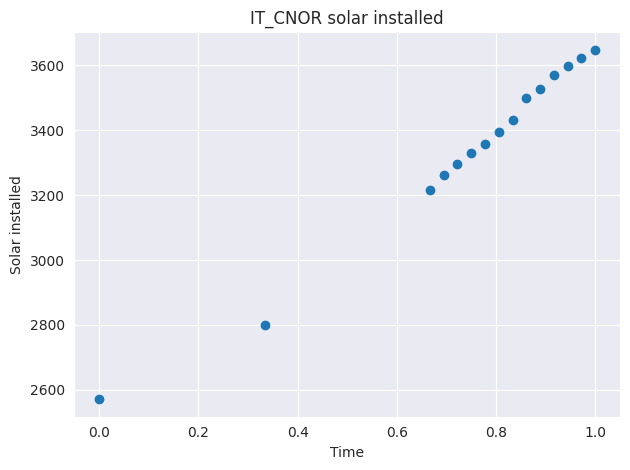

In [32]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
solar2223['time'] = (solar2223['Anno'] - min(solar2223['Anno']))*1.0/3 
solar24['time'] = solar24['Mese']/12.0 / 3 + max(solar2223['time'])

# adding to solar24 the latest installation of 2023
solar24['Solar_installed'] = solar24['Solar_installed'] + solar2223['Solar_installed'].iloc[-1]

# removing extra features
solar2223 = solar2223[['Anno','time','Solar_installed']]
solar24 = solar24[['Anno','time','Solar_installed']]

# concatenate
solar = pd.concat([solar2223,solar24], ignore_index = True)
solar
plt.scatter(solar['time'],solar['Solar_installed'])
plt.xlabel('Time')
plt.ylabel('Solar installed')
plt.title(f'{sel_zone} solar installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/solar_installed.png')
plt.show()

As done for IT_NORD, we can attempt a parabolic fit on the first 3 points, and then a linear one on the last ones.

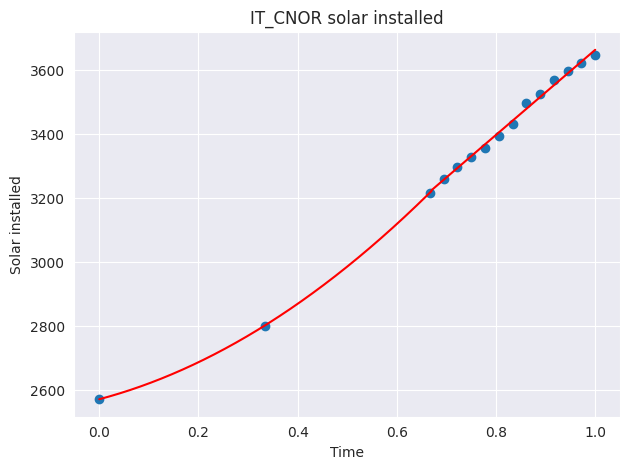

In [33]:
# set threshold that delines where to stop fitting
threshold = 0.67

# FIT 1     FIT 1    FIT 1    FIT 1     FIT 1    FIT 1    FIT 1    FIT 1    FIT 1
# get the points to fit at left (parabolic)
x_to_fit1 = solar[solar['time'] < threshold]['time']
y_to_fit1 = solar[solar['time'] < threshold]['Solar_installed']
# get the points for plotting line
x_fitted1 = df_actuals[df_actuals['time'] < threshold]['time']
# fitting
xv1, yv1, a1, b1, c1 = parab_fit(x_to_fit1, y_to_fit1, x_fitted1)


# FIT 2     FIT 2    FIT 2    FIT 2     FIT 2    FIT 2    FIT 2    FIT 2    FIT 2
# get the points to fit at right (linear)
x_to_fit2 = solar[solar['time'] >= threshold]['time']
y_to_fit2 = solar[solar['time'] >= threshold]['Solar_installed']
# get the points for plotting line
x_fitted2 = df_actuals[df_actuals['time'] >= threshold]['time']
# fitting
xv2, yv2, a2, b2 = lin_fit(x_to_fit2, y_to_fit2, x_fitted2)

# plotting results
plt.scatter(solar['time'],solar['Solar_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.plot(xv2, yv2, color = 'red')
plt.xlabel('Time')
plt.ylabel('Solar installed')
plt.title(f'{sel_zone} solar installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/solar_installed_fitted.png')
plt.show()


In [34]:


# saving the fit results into actuals
df_actuals['solar_installed']=0.
df_actuals.loc[df_actuals['time']< threshold,'solar_installed']=yv1
df_actuals.loc[df_actuals['time']>= threshold,'solar_installed']=yv2
df_actuals



,solar,wind,hydro,generation,load,time,solar_installed
date_time,,,,,,,
2022-01-01 00:00:00+00:00,0.0,19.0,176.0,1438.0,1821.0,0.000000,2571.170000
2022-01-01 01:00:00+00:00,0.0,25.0,153.0,1386.0,1691.0,0.000038,2571.185645
2022-01-01 02:00:00+00:00,0.0,21.0,138.0,1364.0,1605.0,0.000076,2571.201293
2022-01-01 03:00:00+00:00,0.0,22.0,134.0,1283.0,1546.0,0.000114,2571.216942
2022-01-01 04:00:00+00:00,0.0,21.0,133.0,1301.0,1541.0,0.000152,2571.232595
...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,4.0,164.0,1726.0,2839.0,0.999848,3663.933202
2024-12-30 20:00:00+00:00,0.0,2.0,151.0,1733.0,2655.0,0.999886,3663.983845
2024-12-30 21:00:00+00:00,0.0,3.0,111.0,1664.0,2371.0,0.999924,3664.034488


### 2.2.2 IT_CNOR HYDRO

In [35]:
# data from 2022 and 2023
hydro2223 = pd.read_excel('2_gse_data/idrico_GSE_2021_2023.xlsx') 
hydro2223 = hydro2223[hydro2223['Regione'].isin(regions[sel_zone])]  # select regions
hydro2223 = hydro2223.groupby(['Anno'], as_index = False)['Idrico'].agg(Hydro_installed = 'sum') # sum over regions
hydro2223

,Anno,Hydro_installed
0,2021,1169
1,2022,1171
2,2023,1175


In [36]:


# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
hydro24 = installation24[installation24['Fonte'] == 'Idroelettrico']  # select source

# select regions and order by month
hydro24 = hydro24[hydro24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
hydro24 = hydro24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
hydro24 = hydro24.groupby(['Anno','Mese'], as_index = False).sum()
# compute installed power as cumsum
hydro24['Hydro_installed'] = hydro24['Potenza attiva nominale (MW)'].cumsum()
hydro24 = hydro24[['Anno','Mese','Hydro_installed']]
hydro24



,Anno,Mese,Hydro_installed
0,2024,10.0,1.494
1,2024,11.0,2.958


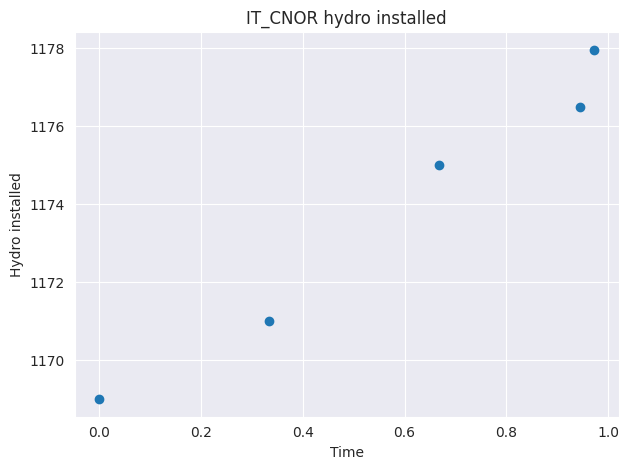

In [37]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
hydro2223['time'] = (hydro2223['Anno'] - min(hydro2223['Anno']))*1.0/3 
hydro24['time'] = hydro24['Mese']/12.0 / 3 + max(hydro2223['time'])

# adding to solar24 the latest installation of 2023
hydro24['Hydro_installed'] = hydro24['Hydro_installed'] + hydro2223['Hydro_installed'].iloc[-1]

# removing extra features
hydro2223 = hydro2223[['Anno','time','Hydro_installed']]
hydro24 = hydro24[['Anno','time','Hydro_installed']]

# concatenate
hydro = pd.concat([hydro2223,hydro24], ignore_index = True)
hydro
plt.scatter(hydro['time'],hydro['Hydro_installed'])
plt.xlabel('Time')
plt.ylabel('Hydro installed')
plt.title(f'{sel_zone} hydro installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/hydro_installed.png')
plt.show()

Points are sparse and not much far one from the other (difference lower than 1/1000). A "bad" linear fit will do the job

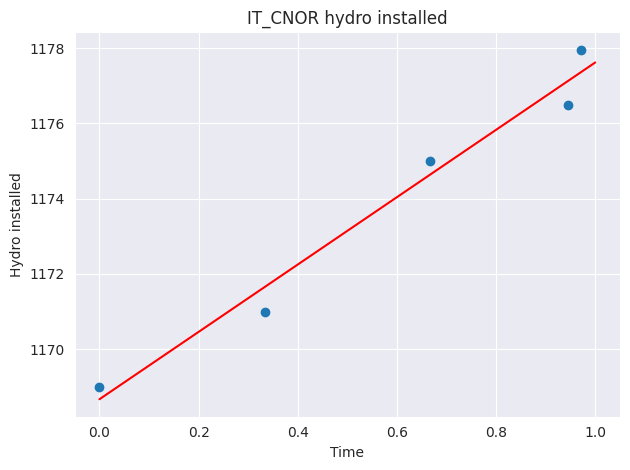

In [38]:

# FIT 
# get the points to fit at left (linear)
x_to_fit1 = hydro['time']
y_to_fit1 = hydro['Hydro_installed']
# get the points for plotting line
x_fitted1 = df_actuals['time']
# fitting
xv1, yv1, a1, b1 = lin_fit(x_to_fit1, y_to_fit1, x_fitted1)

# plotting results
plt.scatter(hydro['time'],hydro['Hydro_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.xlabel('Time')
plt.ylabel('Hydro installed')
plt.title(f'{sel_zone} hydro installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/hydro_installed_fitted.png')
plt.show()


In [39]:
# saving the fit results into actuals
df_actuals['hydro_installed']=0.
df_actuals.loc[df_actuals['time']< threshold,'hydro_installed']=yv1
df_actuals.loc[df_actuals['time']>= threshold,'hydro_installed']=yv2
df_actuals



,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed
date_time,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,19.0,176.0,1438.0,1821.0,0.000000,2571.170000,1168.667728
2022-01-01 01:00:00+00:00,0.0,25.0,153.0,1386.0,1691.0,0.000038,2571.185645,1168.668069
2022-01-01 02:00:00+00:00,0.0,21.0,138.0,1364.0,1605.0,0.000076,2571.201293,1168.668410
2022-01-01 03:00:00+00:00,0.0,22.0,134.0,1283.0,1546.0,0.000114,2571.216942,1168.668750
2022-01-01 04:00:00+00:00,0.0,21.0,133.0,1301.0,1541.0,0.000152,2571.232595,1168.669091
...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,4.0,164.0,1726.0,2839.0,0.999848,3663.933202,3663.933202
2024-12-30 20:00:00+00:00,0.0,2.0,151.0,1733.0,2655.0,0.999886,3663.983845,3663.983845
2024-12-30 21:00:00+00:00,0.0,3.0,111.0,1664.0,2371.0,0.999924,3664.034488,3664.034488


### 2.2.3 IT_CNOR WIND INSTALLED

In [40]:
# data from 2022 and 2023
wind2223 = pd.read_csv('2_gse_data/eolico_GSE_2021_2023.csv', sep =';') 
print(wind2223.columns)
wind2223 = wind2223[wind2223['Regione'].isin(regions[sel_zone])]  # select regions
wind2223 = wind2223.groupby(['Anno'], as_index = False)['Valore'].agg(Wind_installed = 'sum') # sum over regions
wind2223

Index(['Regione', 'Valore', 'Anno'], dtype='object')


,Anno,Wind_installed
0,2021,166
1,2022,166
2,2023,166


In [41]:
# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
wind24 = installation24[installation24['Fonte'] == 'Eolico']  # select source

# select regions and order by month
wind24 = wind24[wind24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
wind24 = wind24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
wind24 = wind24.groupby(['Anno','Mese'], as_index = False).sum()

# compute installed power as cumsum
wind24['Wind_installed'] = wind24['Potenza attiva nominale (MW)'].cumsum()
wind24 = wind24[['Anno','Mese','Wind_installed']]
wind24



,Anno,Mese,Wind_installed
0,2024,5.0,0.005
1,2024,9.0,0.980
2,2024,11.0,1.880


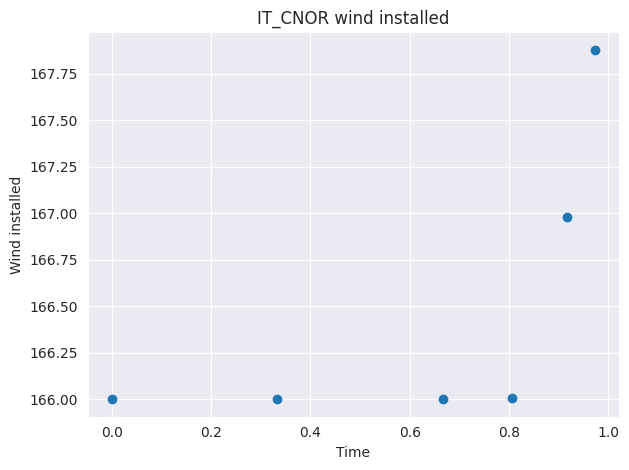

In [42]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
wind2223['time'] = (wind2223['Anno'] - min(wind2223['Anno']))*1.0/3 
wind24['time'] = wind24['Mese']/12.0 / 3 + max(wind2223['time'])

# adding to solar24 the latest installation of 2023
wind24['Wind_installed'] = wind24['Wind_installed'] + wind2223['Wind_installed'].iloc[-1]

# removing extra features
wind2223 = wind2223[['Anno','time','Wind_installed']]
wind24 = wind24[['Anno','time','Wind_installed']]

# concatenate
wind = pd.concat([wind2223,wind24], ignore_index = True)
wind
plt.scatter(wind['time'],wind['Wind_installed'])
plt.xlabel('Time')
plt.ylabel('Wind installed')
plt.title(f'{sel_zone} wind installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/wind_installed.png')
plt.show()


Even here there isn't much. Just some small installations at the end of 2024. We'll fit those

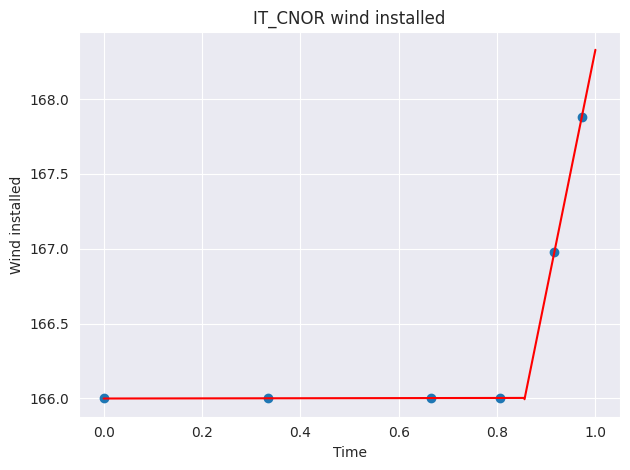

In [43]:
# setting a threshold for the fits
threshold = 0.8558
# FIT 1     FIT 1    FIT 1    FIT 1     FIT 1    FIT 1    FIT 1    FIT 1    FIT 1
# get the points to fit left 
x_to_fit1 = wind[wind['time'] < threshold]['time']
y_to_fit1 = wind[wind['time'] < threshold]['Wind_installed']
# get the points for plotting line
x_fitted1 = df_actuals[df_actuals['time'] < threshold]['time']
# fitting
xv1, yv1, a1, b1 = lin_fit(x_to_fit1, y_to_fit1, x_fitted1)


# FIT 2     FIT 2    FIT 2    FIT 2     FIT 2    FIT 2    FIT 2    FIT 2    FIT 2
# get the points to fit right
x_to_fit2 = wind[wind['time'] >= threshold]['time']
y_to_fit2 = wind[wind['time'] >= threshold]['Wind_installed']
# get the points for plotting line
x_fitted2 = df_actuals[df_actuals['time'] >= threshold]['time']
# fitting
xv2, yv2, a2, b2 = lin_fit(x_to_fit2, y_to_fit2, x_fitted2)

# plotting results
plt.scatter(wind['time'],wind['Wind_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.plot(xv2, yv2, color = 'red')
plt.xlabel('Time')
plt.ylabel('Wind installed')
plt.title(f'{sel_zone} wind installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/wind_installed_fitted.png')
plt.show()

In [44]:
# assign values to actuals df
df_actuals['wind_installed'] = 0.0
df_actuals.loc[df_actuals['time'] < threshold, 'wind_installed'] = yv1
df_actuals.loc[df_actuals['time'] >= threshold, 'wind_installed'] = yv2
df_actuals



,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed,wind_installed
date_time,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,19.0,176.0,1438.0,1821.0,0.000000,2571.170000,1168.667728,165.999198
2022-01-01 01:00:00+00:00,0.0,25.0,153.0,1386.0,1691.0,0.000038,2571.185645,1168.668069,165.999198
2022-01-01 02:00:00+00:00,0.0,21.0,138.0,1364.0,1605.0,0.000076,2571.201293,1168.668410,165.999198
2022-01-01 03:00:00+00:00,0.0,22.0,134.0,1283.0,1546.0,0.000114,2571.216942,1168.668750,165.999198
2022-01-01 04:00:00+00:00,0.0,21.0,133.0,1301.0,1541.0,0.000152,2571.232595,1168.669091,165.999198
...,...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,4.0,164.0,1726.0,2839.0,0.999848,3663.933202,3663.933202,168.327534
2024-12-30 20:00:00+00:00,0.0,2.0,151.0,1733.0,2655.0,0.999886,3663.983845,3663.983845,168.328151
2024-12-30 21:00:00+00:00,0.0,3.0,111.0,1664.0,2371.0,0.999924,3664.034488,3664.034488,168.328767


### 2.2.4 IT_CNOR REMOVING ACTUALS OUTLIERS
Even here there are visible outliers in solar and hydro. Let's remove them

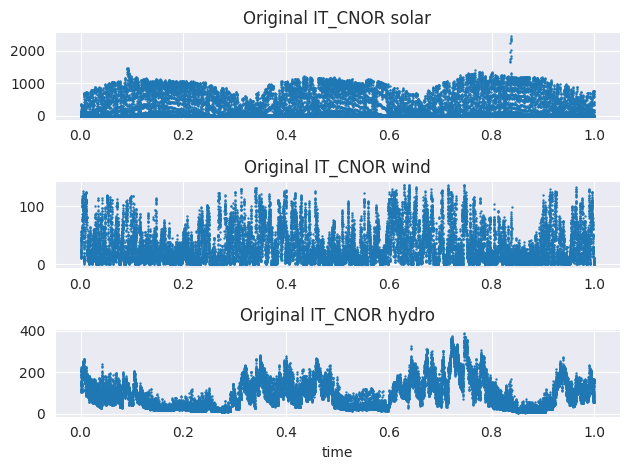

In [45]:
fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar'], s =0.5)
ax[1].scatter(df_actuals['time'],df_actuals['wind'], s =0.5)
ax[2].scatter(df_actuals['time'],df_actuals['hydro'], s =0.5)
ax[0].set_title(f'Original {sel_zone} solar')
ax[1].set_title(f'Original {sel_zone} wind')
ax[2].set_title(f'Original {sel_zone} hydro')
ax[2].set_xlabel('time')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/original_actuals_features.png')
plt.show()


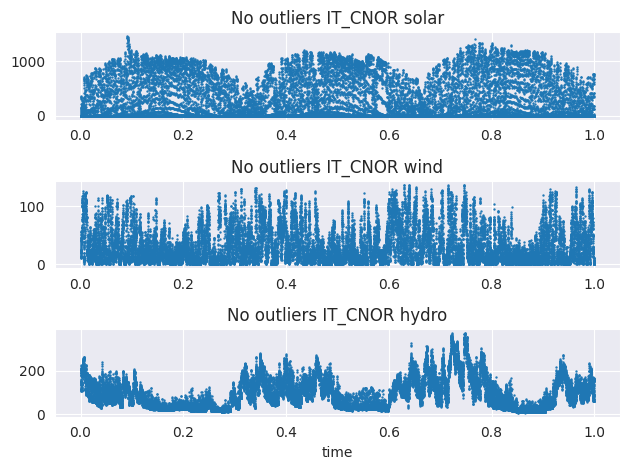

In [46]:
# removing outliers
df_actuals = df_actuals[df_actuals['solar']< 1500]
#df_actuals = df_actuals[df_actuals['wind']< 180]
df_actuals = df_actuals[df_actuals['hydro']< 375]

fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar'], s =0.5)
ax[1].scatter(df_actuals['time'],df_actuals['wind'], s =0.5)
ax[2].scatter(df_actuals['time'],df_actuals['hydro'], s =0.5)
ax[0].set_title(f'No outliers {sel_zone} solar')
ax[1].set_title(f'No outliers {sel_zone} wind')
ax[2].set_title(f'No outliers {sel_zone} hydro')
ax[2].set_xlabel('time')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/no_outliers_actuals_features.png')
plt.show()

### 2.2.5 IT_CNOR DETRENDED PRODUCTIONS

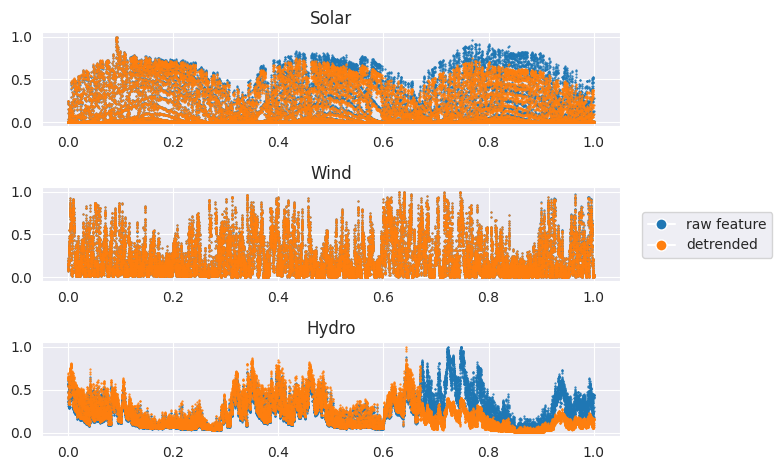

In [47]:
df_actuals['detrended_solar'] = df_actuals['solar'] / df_actuals['solar_installed']
df_actuals['detrended_wind'] = df_actuals['wind'] / df_actuals['wind_installed']
df_actuals['detrended_hydro'] = df_actuals['hydro'] / df_actuals['hydro_installed']

fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar']/max(df_actuals['solar']), s = 0.3, label = 'Original')
ax[0].scatter(df_actuals['time'],df_actuals['detrended_solar']/max(df_actuals['detrended_solar']), s = 0.3, label = 'Detrended')
ax[0].set_title('Solar')

ax[1].scatter(df_actuals['time'],df_actuals['wind']/max(df_actuals['wind']), s = 0.3, label = 'Original')
ax[1].scatter(df_actuals['time'],df_actuals['detrended_wind']/max(df_actuals['detrended_wind']), s = 0.3, label = 'Detrended')
ax[1].set_title('Wind')


ax[2].scatter(df_actuals['time'],df_actuals['hydro']/max(df_actuals['hydro']), s = 0.3, label = 'Original')
ax[2].scatter(df_actuals['time'],df_actuals['detrended_hydro']/max(df_actuals['detrended_hydro']), s = 0.3, label = 'Detrended')
ax[2].set_title('Hydro')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='raw feature',
           markerfacecolor='C0', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='detrended',
           markerfacecolor='C1', markersize=8), 
]
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

### 2.2.6 IT_CNOR load computation

In [48]:
df_actuals['ratio'] = (df_actuals['solar'] + df_actuals['wind'] + df_actuals['hydro']) / df_actuals['load']
df_actuals


,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed,wind_installed,detrended_solar,detrended_wind,detrended_hydro,ratio
date_time,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,19.0,176.0,1438.0,1821.0,0.000000,2571.170000,1168.667728,165.999198,0.0,0.114458,0.150599,0.107084
2022-01-01 01:00:00+00:00,0.0,25.0,153.0,1386.0,1691.0,0.000038,2571.185645,1168.668069,165.999198,0.0,0.150603,0.130918,0.105263
2022-01-01 02:00:00+00:00,0.0,21.0,138.0,1364.0,1605.0,0.000076,2571.201293,1168.668410,165.999198,0.0,0.126507,0.118083,0.099065
2022-01-01 03:00:00+00:00,0.0,22.0,134.0,1283.0,1546.0,0.000114,2571.216942,1168.668750,165.999198,0.0,0.132531,0.114660,0.100906
2022-01-01 04:00:00+00:00,0.0,21.0,133.0,1301.0,1541.0,0.000152,2571.232595,1168.669091,165.999198,0.0,0.126507,0.113805,0.099935
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,4.0,164.0,1726.0,2839.0,0.999848,3663.933202,3663.933202,168.327534,0.0,0.023763,0.044761,0.059176
2024-12-30 20:00:00+00:00,0.0,2.0,151.0,1733.0,2655.0,0.999886,3663.983845,3663.983845,168.328151,0.0,0.011882,0.041212,0.057627
2024-12-30 21:00:00+00:00,0.0,3.0,111.0,1664.0,2371.0,0.999924,3664.034488,3664.034488,168.328767,0.0,0.017822,0.030294,0.048081


In [49]:
# save the file 
df_actuals.to_csv(f'2_outputs/{sel_zone}_installation_detrended_actuals.csv')


## 2.3 IT_CSUD
### 2.3.1 IT_CSUD SOLAR

In [50]:
# Selected zone
sel_zone = 'IT_CSUD'
# for saving installation data
df_installed_nord = pd.DataFrame()

# making directory for saving plots
directory_name = f'2_plots/{sel_zone}'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

# directory for saving actuals
directory_name = f'2_outputs'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")


Directory '2_plots/IT_CSUD' already exists.
Directory '2_outputs' already exists.


### Getting time param from actuals

In [51]:
years = [2022,2023,2024] # selection of years
df_actuals = pd.DataFrame()

# extract actuals files
for year in years:
    filename = f"2_gse_data/{year}_actuals.zst"
    df = pd.read_parquet(filename)  # this reads .zst files efficiently
    df = df[df['zone'] == sel_zone]
    df_actuals = pd.concat([df_actuals, df])

# check for duplicates date time information
df_actuals['datetime'] = df_actuals.index.tz_localize(None)
num_duplicates = df_actuals.duplicated(subset='datetime').sum()
print(f"Number of duplicate datetime entries in {sel_zone} actuals: {num_duplicates}")

# remove last day of 2024 (problem in acquisition of data
df_actuals = df_actuals[:(np.shape(df_actuals)[0]-96)]

# grouping by hours (2024 changes timeframe acquisition)
df_actuals = df_actuals.resample('1h').agg({'solar': 'sum',
                                        'wind': 'sum',
                                        'hydro': 'sum',
                                        'generation':'sum',
                                        'load':'sum'}) 

# then making a growing time param
df_actuals['time'] = np.linspace(0, 1, len(df_actuals))

Number of duplicate datetime entries in IT_CSUD actuals: 0


In [52]:
# data from 2022 and 2023
solar2223 = pd.read_excel('2_gse_data/solare_GSE_2021_2023.xlsx') 
solar2223 = solar2223[solar2223['Regione'].isin(regions[sel_zone])]  # select regions
solar2223 = solar2223.groupby(['Anno'], as_index = False)['Potenza installata (MW)'].agg(Solar_installed = 'sum') # sum over regions
solar2223


,Anno,Solar_installed
0,2021,3193.84
1,2022,3573.65
2,2023,4228.10


In [53]:
# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
solar24 = installation24[installation24['Fonte']=='Solare']  # select source

# select regions and order by month
solar24 = solar24[solar24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
solar24 = solar24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
solar24 = solar24.groupby(['Anno','Mese'], as_index = False).sum()
# compute installed power as cumsum
solar24['Solar_installed'] = solar24['Potenza attiva nominale (MW)'].cumsum()
solar24 = solar24[['Anno','Mese','Solar_installed']]
solar24

,Anno,Mese,Solar_installed
0,2024,1.0,193.18689
1,2024,2.0,253.18117
2,2024,3.0,326.32247
3,2024,4.0,459.06389
4,2024,5.0,522.31059
5,2024,6.0,657.99834
6,2024,7.0,815.02439
7,2024,8.0,1009.57469
8,2024,9.0,1136.62497
9,2024,10.0,1303.85919


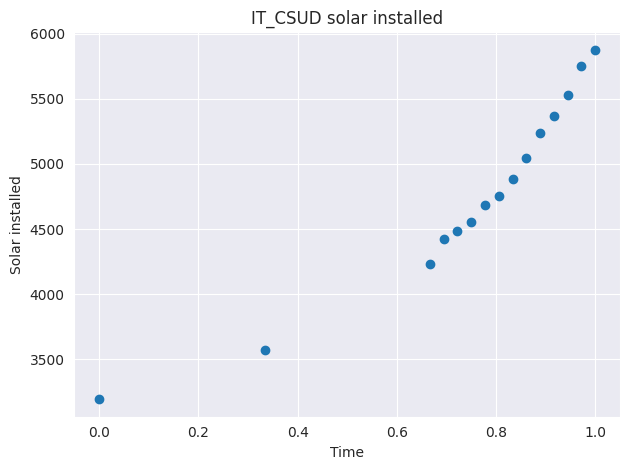

In [54]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
solar2223['time'] = (solar2223['Anno'] - min(solar2223['Anno']))*1.0/3 
solar24['time'] = solar24['Mese']/12.0 / 3 + max(solar2223['time'])

# adding to solar24 the latest installation of 2023
solar24['Solar_installed'] = solar24['Solar_installed'] + solar2223['Solar_installed'].iloc[-1]

# removing extra features
solar2223 = solar2223[['Anno','time','Solar_installed']]
solar24 = solar24[['Anno','time','Solar_installed']]

# concatenate
solar = pd.concat([solar2223,solar24], ignore_index = True)
solar
plt.scatter(solar['time'],solar['Solar_installed'])
plt.xlabel('Time')
plt.ylabel('Solar installed')
plt.title(f'{sel_zone} solar installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/solar_installed.png')
plt.show()


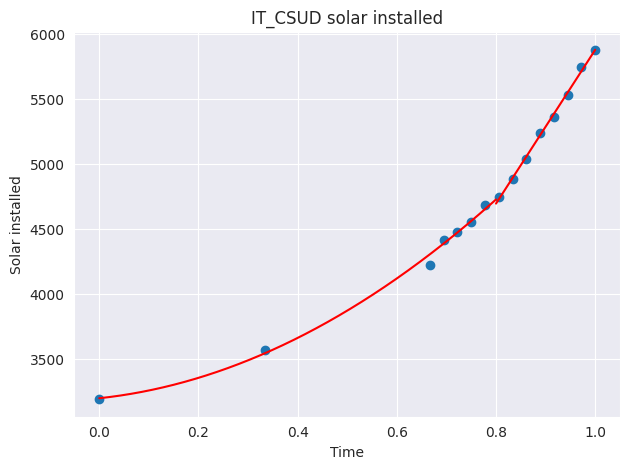

In [55]:
# set threshold that delines where to stop fitting
threshold = 0.8

# FIT 1     FIT 1    FIT 1    FIT 1     FIT 1    FIT 1    FIT 1    FIT 1    FIT 1
# get the points to fit at left (parabolic)
x_to_fit1 = solar[solar['time'] < threshold]['time']
y_to_fit1 = solar[solar['time'] < threshold]['Solar_installed']
# get the points for plotting line
x_fitted1 = df_actuals[df_actuals['time'] < threshold]['time']
# fitting
xv1, yv1, a1, b1, c1 = parab_fit(x_to_fit1, y_to_fit1, x_fitted1)


# FIT 2     FIT 2    FIT 2    FIT 2     FIT 2    FIT 2    FIT 2    FIT 2    FIT 2
# get the points to fit at right (linear)
x_to_fit2 = solar[solar['time'] >= threshold]['time']
y_to_fit2 = solar[solar['time'] >= threshold]['Solar_installed']
# get the points for plotting line
x_fitted2 = df_actuals[df_actuals['time'] >= threshold]['time']
# fitting
xv2, yv2, a2, b2 = lin_fit(x_to_fit2, y_to_fit2, x_fitted2)

# plotting results
plt.scatter(solar['time'],solar['Solar_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.plot(xv2, yv2, color = 'red')
plt.xlabel('Time')
plt.ylabel('Solar installed')
plt.title(f'{sel_zone} solar installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/solar_installed_fitted.png')
plt.show()



In [56]:
# saving the fit results into actuals
df_actuals['solar_installed']=0.
df_actuals.loc[df_actuals['time']< threshold,'solar_installed']=yv1
df_actuals.loc[df_actuals['time']>= threshold,'solar_installed']=yv2
df_actuals


,solar,wind,hydro,generation,load,time,solar_installed
date_time,,,,,,,
2022-01-01 00:00:00+00:00,0.0,297.0,654.0,1688.0,4216.0,0.000000,3201.581844
2022-01-01 01:00:00+00:00,0.0,313.0,560.0,1602.0,3822.0,0.000038,3201.597353
2022-01-01 02:00:00+00:00,0.0,333.0,462.0,1432.0,3503.0,0.000076,3201.612868
2022-01-01 03:00:00+00:00,0.0,307.0,444.0,1363.0,3282.0,0.000114,3201.628388
2022-01-01 04:00:00+00:00,0.0,215.0,460.0,1278.0,3259.0,0.000152,3201.643914
...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,9.0,402.0,3644.0,6428.0,0.999848,5878.941864
2024-12-30 20:00:00+00:00,0.0,8.0,364.0,3507.0,5972.0,0.999886,5879.166831
2024-12-30 21:00:00+00:00,0.0,19.0,361.0,2873.0,5435.0,0.999924,5879.391799


### 2.3.2 IT_CSUD HYDRO

In [57]:
# data from 2022 and 2023
hydro2223 = pd.read_excel('2_gse_data/idrico_GSE_2021_2023.xlsx') 
hydro2223 = hydro2223[hydro2223['Regione'].isin(regions[sel_zone])]  # select regions
hydro2223 = hydro2223.groupby(['Anno'], as_index = False)['Idrico'].agg(Hydro_installed = 'sum') # sum over regions
hydro2223



,Anno,Hydro_installed
0,2021,1787
1,2022,1822
2,2023,1822


In [58]:
# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
hydro24 = installation24[installation24['Fonte'] == 'Idroelettrico']  # select source

# select regions and order by month
hydro24 = hydro24[hydro24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
hydro24 = hydro24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
hydro24 = hydro24.groupby(['Anno','Mese'], as_index = False).sum()
# compute installed power as cumsum
hydro24['Hydro_installed'] = hydro24['Potenza attiva nominale (MW)'].cumsum()
hydro24 = hydro24[['Anno','Mese','Hydro_installed']]
hydro24


,Anno,Mese,Hydro_installed
0,2024,9.0,0.15


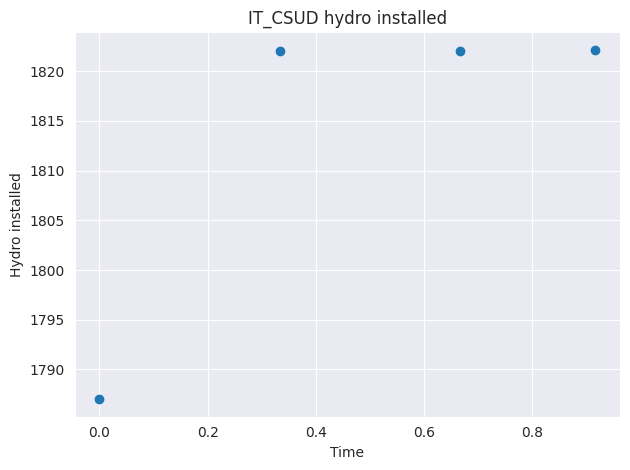

In [59]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
hydro2223['time'] = (hydro2223['Anno'] - min(hydro2223['Anno']))*1.0/3 
hydro24['time'] = hydro24['Mese']/12.0 / 3 + max(hydro2223['time'])

# adding to solar24 the latest installation of 2023
hydro24['Hydro_installed'] = hydro24['Hydro_installed'] + hydro2223['Hydro_installed'].iloc[-1]

# removing extra features
hydro2223 = hydro2223[['Anno','time','Hydro_installed']]
hydro24 = hydro24[['Anno','time','Hydro_installed']]

# concatenate
hydro = pd.concat([hydro2223,hydro24], ignore_index = True)
hydro
plt.scatter(hydro['time'],hydro['Hydro_installed'])
plt.xlabel('Time')
plt.ylabel('Hydro installed')
plt.title(f'{sel_zone} hydro installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/hydro_installed.png')
plt.show()

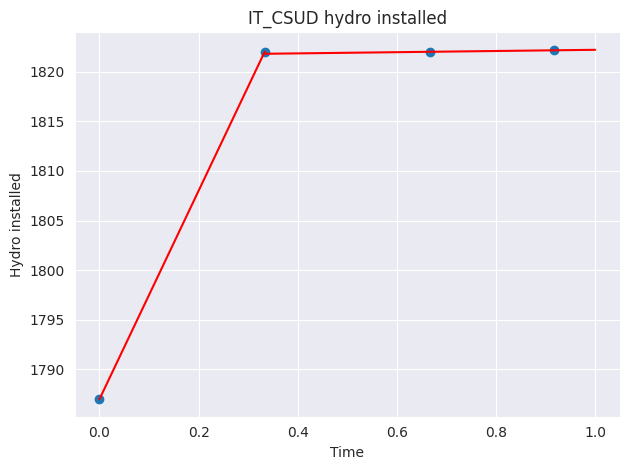

In [60]:


# set threshold that delines where to stop fitting
threshold = 0.3334

# FIT 1     FIT 1    FIT 1    FIT 1     FIT 1    FIT 1    FIT 1    FIT 1    FIT 1
# get the points to fit at left (linear)
x_to_fit1 = hydro[hydro['time'] < threshold]['time']
y_to_fit1 = hydro[hydro['time'] < threshold]['Hydro_installed']
# get the points for plotting line
x_fitted1 = df_actuals[df_actuals['time'] < threshold]['time']
# fitting
xv1, yv1, a1, b1 = lin_fit(x_to_fit1, y_to_fit1, x_fitted1)


# FIT 2     FIT 2    FIT 2    FIT 2     FIT 2    FIT 2    FIT 2    FIT 2    FIT 2
# get the points to fit at right (linear)
x_to_fit2 = hydro[hydro['time'] >= threshold]['time']
y_to_fit2 = hydro[hydro['time'] >= threshold]['Hydro_installed']
# get the points for plotting line
x_fitted2 = df_actuals[df_actuals['time'] >= threshold]['time']
# fitting
xv2, yv2, a2, b2 = lin_fit(x_to_fit2, y_to_fit2, x_fitted2)

# plotting results
plt.scatter(hydro['time'],hydro['Hydro_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.plot(xv2, yv2, color = 'red')
plt.xlabel('Time')
plt.ylabel('Hydro installed')
plt.title(f'{sel_zone} hydro installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/hydro_installed_fitted.png')
plt.show()



In [61]:
# saving the fit results into actuals
df_actuals['hydro_installed']=0.
df_actuals.loc[df_actuals['time']< threshold,'hydro_installed']=yv1
df_actuals.loc[df_actuals['time']>= threshold,'hydro_installed']=yv2
df_actuals



,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed
date_time,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,297.0,654.0,1688.0,4216.0,0.000000,3201.581844,1787.000000
2022-01-01 01:00:00+00:00,0.0,313.0,560.0,1602.0,3822.0,0.000038,3201.597353,1787.003996
2022-01-01 02:00:00+00:00,0.0,333.0,462.0,1432.0,3503.0,0.000076,3201.612868,1787.007991
2022-01-01 03:00:00+00:00,0.0,307.0,444.0,1363.0,3282.0,0.000114,3201.628388,1787.011987
2022-01-01 04:00:00+00:00,0.0,215.0,460.0,1278.0,3259.0,0.000152,3201.643914,1787.015982
...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,9.0,402.0,3644.0,6428.0,0.999848,5878.941864,1822.199909
2024-12-30 20:00:00+00:00,0.0,8.0,364.0,3507.0,5972.0,0.999886,5879.166831,1822.199932
2024-12-30 21:00:00+00:00,0.0,19.0,361.0,2873.0,5435.0,0.999924,5879.391799,1822.199954


### 2.3.3 IT_CSUD WIND INSTALLED

In [62]:
# data from 2022 and 2023
wind2223 = pd.read_csv('2_gse_data/eolico_GSE_2021_2023.csv', sep =';') 
print(wind2223.columns)
wind2223 = wind2223[wind2223['Regione'].isin(regions[sel_zone])]  # select regions
wind2223 = wind2223.groupby(['Anno'], as_index = False)['Valore'].agg(Wind_installed = 'sum') # sum over regions
wind2223



Index(['Regione', 'Valore', 'Anno'], dtype='object')


,Anno,Wind_installed
0,2021,2112
1,2022,2216
2,2023,2305


In [63]:
# data from 2024
installation24 = pd.read_excel('2_gse_data/installazioni_mensili_2024.xlsx')
wind24 = installation24[installation24['Fonte'] == 'Eolico']  # select source

# select regions and order by month
wind24 = wind24[wind24['Regione'].isin(regions[sel_zone])].sort_values(by ='Mese', ascending = True) 
wind24 = wind24[['Anno','Mese','Potenza attiva nominale (MW)']]

# group by month
wind24 = wind24.groupby(['Anno','Mese'], as_index = False).sum()

# compute installed power as cumsum
wind24['Wind_installed'] = wind24['Potenza attiva nominale (MW)'].cumsum()
wind24 = wind24[['Anno','Mese','Wind_installed']]
wind24


,Anno,Mese,Wind_installed
0,2024,1.0,2.4928
1,2024,2.0,37.1428
2,2024,4.0,68.3428
3,2024,5.0,118.1428
4,2024,6.0,216.6428
5,2024,9.0,217.6178
6,2024,10.0,221.6178
7,2024,11.0,222.1168
8,2024,12.0,223.1158


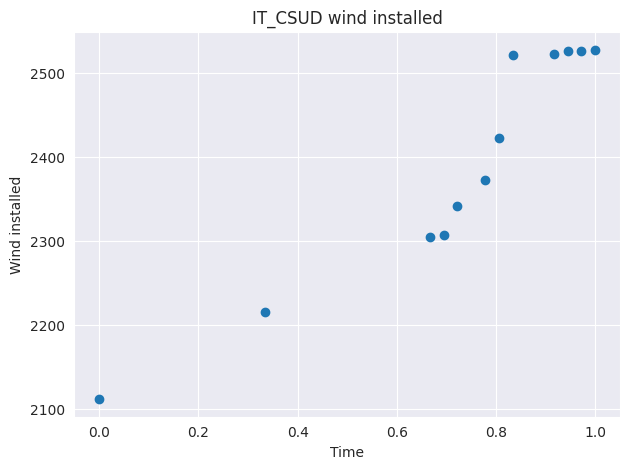

In [64]:
# merge appropriately 22-23 and 24
# creating a time parameter going from 0 (start 2021) to 1 (end 2024)
wind2223['time'] = (wind2223['Anno'] - min(wind2223['Anno']))*1.0/3 
wind24['time'] = wind24['Mese']/12.0 / 3 + max(wind2223['time'])

# adding to solar24 the latest installation of 2023
wind24['Wind_installed'] = wind24['Wind_installed'] + wind2223['Wind_installed'].iloc[-1]

# removing extra features
wind2223 = wind2223[['Anno','time','Wind_installed']]
wind24 = wind24[['Anno','time','Wind_installed']]

# concatenate
wind = pd.concat([wind2223,wind24], ignore_index = True)
wind
plt.scatter(wind['time'],wind['Wind_installed'])
plt.xlabel('Time')
plt.ylabel('Wind installed')
plt.title(f'{sel_zone} wind installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/wind_installed.png')
plt.show()



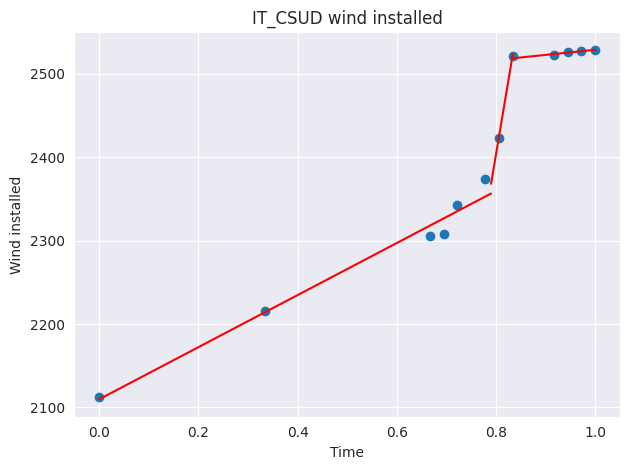

In [65]:
#set threshold that delines where to stop fitting
threshold12 = 0.79
threshold23 = 0.834

# FIT 1     FIT 1    FIT 1    FIT 1     FIT 1    FIT 1    FIT 1    FIT 1    FIT 1
# get the points to fit at left (linear)
x_to_fit1 = wind[wind['time'] < threshold12]['time']
y_to_fit1 = wind[wind['time'] < threshold12]['Wind_installed']
# get the points for plotting line
x_fitted1 = df_actuals[df_actuals['time'] < threshold12]['time']
# fitting
xv1, yv1, a1, b1 = lin_fit(x_to_fit1, y_to_fit1, x_fitted1)


# FIT 2    FIT 2    FIT 2    FIT 2    FIT 2    FIT 2    FIT 2    FIT 2    FIT 2    FIT 2    
# get the points to fit at left (parabolic)
# select the relevant range in wind
fit2_range = (wind['time'] >= threshold12) & (wind['time'] < threshold23)
# extract x and y to fit
x_to_fit2 = wind.loc[fit2_range, 'time']
y_to_fit2 = wind.loc[fit2_range, 'Wind_installed']
# get the points for plotting line
fit_plot2_range = (df_actuals['time'] >= threshold12) & (df_actuals['time'] < threshold23)
x_fitted2 = df_actuals.loc[fit_plot2_range, 'time']
# fitting
xv2, yv2, a2, b2 = lin_fit(x_to_fit2, y_to_fit2, x_fitted2)


# FIT 3     FIT 3     FIT 3     FIT 3     FIT 3     FIT 3     FIT 3     
# get the points to fit at right (linear)
x_to_fit3 = wind[wind['time'] >= threshold23]['time']
y_to_fit3 = wind[wind['time'] >= threshold23]['Wind_installed']
# get the points for plotting line
x_fitted3 = df_actuals[df_actuals['time'] >= threshold23]['time']
# fitting
xv3, yv3, a3, b3 = lin_fit(x_to_fit3, y_to_fit3, x_fitted3)

# plotting results
plt.scatter(wind['time'],wind['Wind_installed'])
plt.plot(xv1, yv1, color = 'red')
plt.plot(xv2, yv2, color = 'red')
plt.plot(xv3, yv3, color = 'red')
plt.xlabel('Time')
plt.ylabel('Wind installed')
plt.title(f'{sel_zone} wind installed')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/wind_installed_fitted.png')
plt.show()

In [66]:
# assign values to actuals
df_actuals['wind_installed'] = np.nan
df_actuals.loc[df_actuals['time'] < threshold12, 'wind_installed'] = yv1
df_actuals.loc[(df_actuals['time'] >= threshold12) & (df_actuals['time'] < threshold23), 'wind_installed'] = yv2
df_actuals.loc[df_actuals['time'] >= threshold23, 'wind_installed'] = yv3
df_actuals


,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed,wind_installed
date_time,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,297.0,654.0,1688.0,4216.0,0.000000,3201.581844,1787.000000,2109.827136
2022-01-01 01:00:00+00:00,0.0,313.0,560.0,1602.0,3822.0,0.000038,3201.597353,1787.003996,2109.839012
2022-01-01 02:00:00+00:00,0.0,333.0,462.0,1432.0,3503.0,0.000076,3201.612868,1787.007991,2109.850889
2022-01-01 03:00:00+00:00,0.0,307.0,444.0,1363.0,3282.0,0.000114,3201.628388,1787.011987,2109.862766
2022-01-01 04:00:00+00:00,0.0,215.0,460.0,1278.0,3259.0,0.000152,3201.643914,1787.015982,2109.874643
...,...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,9.0,402.0,3644.0,6428.0,0.999848,5878.941864,1822.199909,2528.656688
2024-12-30 20:00:00+00:00,0.0,8.0,364.0,3507.0,5972.0,0.999886,5879.166831,1822.199932,2528.659016
2024-12-30 21:00:00+00:00,0.0,19.0,361.0,2873.0,5435.0,0.999924,5879.391799,1822.199954,2528.661344


### 2.3.4 IT_CSUD REMOVING ACTUALS OUTLIERS

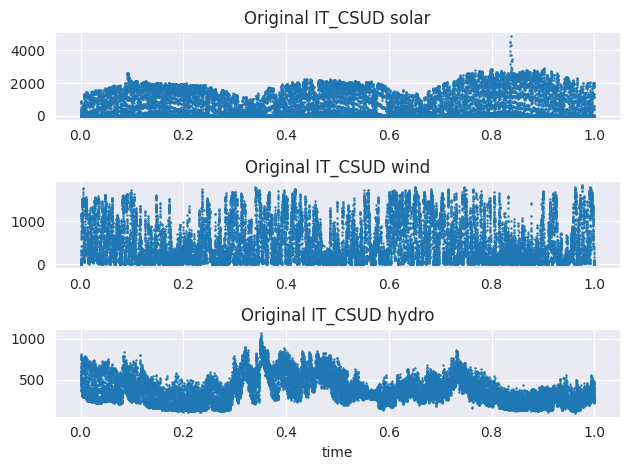

In [67]:
fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar'], s =0.5)
ax[1].scatter(df_actuals['time'],df_actuals['wind'], s =0.5)
ax[2].scatter(df_actuals['time'],df_actuals['hydro'], s =0.5)
ax[0].set_title(f'Original {sel_zone} solar')
ax[1].set_title(f'Original {sel_zone} wind')
ax[2].set_title(f'Original {sel_zone} hydro')
ax[2].set_xlabel('time')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/original_actuals_features.png')
plt.show()



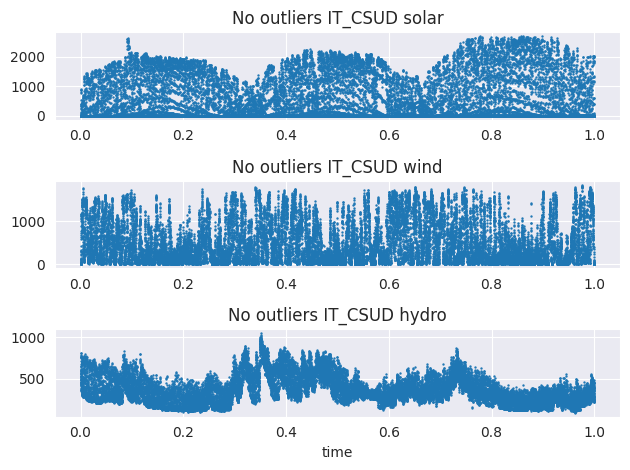

In [68]:
# removing outliers
df_actuals = df_actuals[df_actuals['solar']< 2700]
#df_actuals = df_actuals[df_actuals['wind']< 180]
df_actuals = df_actuals[df_actuals['hydro']< 1050]

fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar'], s =0.5)
ax[1].scatter(df_actuals['time'],df_actuals['wind'], s =0.5)
ax[2].scatter(df_actuals['time'],df_actuals['hydro'], s =0.5)
ax[0].set_title(f'No outliers {sel_zone} solar')
ax[1].set_title(f'No outliers {sel_zone} wind')
ax[2].set_title(f'No outliers {sel_zone} hydro')
ax[2].set_xlabel('time')
plt.tight_layout()
plt.savefig(f'2_plots/{sel_zone}/no_outliers_actuals_features.png')
plt.show()



### 2.3.5 IT_CSUD DETRENDED PRODUCTIONS

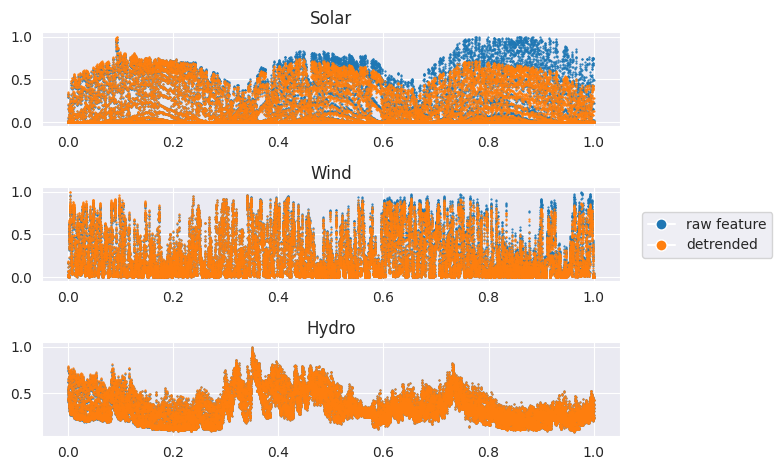

In [69]:
df_actuals['detrended_solar'] = df_actuals['solar'] / df_actuals['solar_installed']
df_actuals['detrended_wind'] = df_actuals['wind'] / df_actuals['wind_installed']
df_actuals['detrended_hydro'] = df_actuals['hydro'] / df_actuals['hydro_installed']

fig, ax = plt.subplots(3)
ax[0].scatter(df_actuals['time'],df_actuals['solar']/max(df_actuals['solar']), s = 0.3, label = 'Original')
ax[0].scatter(df_actuals['time'],df_actuals['detrended_solar']/max(df_actuals['detrended_solar']), s = 0.3, label = 'Detrended')
ax[0].set_title('Solar')

ax[1].scatter(df_actuals['time'],df_actuals['wind']/max(df_actuals['wind']), s = 0.3, label = 'Original')
ax[1].scatter(df_actuals['time'],df_actuals['detrended_wind']/max(df_actuals['detrended_wind']), s = 0.3, label = 'Detrended')
ax[1].set_title('Wind')


ax[2].scatter(df_actuals['time'],df_actuals['hydro']/max(df_actuals['hydro']), s = 0.3, label = 'Original')
ax[2].scatter(df_actuals['time'],df_actuals['detrended_hydro']/max(df_actuals['detrended_hydro']), s = 0.3, label = 'Detrended')
ax[2].set_title('Hydro')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='raw feature',
           markerfacecolor='C0', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='detrended',
           markerfacecolor='C1', markersize=8), 
]
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()



### 2.3.7 IT_CSUD load computation

In [70]:
df_actuals['ratio'] = (df_actuals['solar'] + df_actuals['wind'] + df_actuals['hydro']) / df_actuals['load']
df_actuals



,solar,wind,hydro,generation,load,time,solar_installed,hydro_installed,wind_installed,detrended_solar,detrended_wind,detrended_hydro,ratio
date_time,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,297.0,654.0,1688.0,4216.0,0.000000,3201.581844,1787.000000,2109.827136,0.0,0.140770,0.365976,0.225569
2022-01-01 01:00:00+00:00,0.0,313.0,560.0,1602.0,3822.0,0.000038,3201.597353,1787.003996,2109.839012,0.0,0.148353,0.313374,0.228414
2022-01-01 02:00:00+00:00,0.0,333.0,462.0,1432.0,3503.0,0.000076,3201.612868,1787.007991,2109.850889,0.0,0.157831,0.258533,0.226948
2022-01-01 03:00:00+00:00,0.0,307.0,444.0,1363.0,3282.0,0.000114,3201.628388,1787.011987,2109.862766,0.0,0.145507,0.248459,0.228824
2022-01-01 04:00:00+00:00,0.0,215.0,460.0,1278.0,3259.0,0.000152,3201.643914,1787.015982,2109.874643,0.0,0.101902,0.257412,0.207119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00+00:00,0.0,9.0,402.0,3644.0,6428.0,0.999848,5878.941864,1822.199909,2528.656688,0.0,0.003559,0.220612,0.063939
2024-12-30 20:00:00+00:00,0.0,8.0,364.0,3507.0,5972.0,0.999886,5879.166831,1822.199932,2528.659016,0.0,0.003164,0.199759,0.062291
2024-12-30 21:00:00+00:00,0.0,19.0,361.0,2873.0,5435.0,0.999924,5879.391799,1822.199954,2528.661344,0.0,0.007514,0.198112,0.069917


In [71]:
# save the file 
df_actuals.to_csv(f'2_outputs/{sel_zone}_installation_detrended_actuals.csv')